## INITIALIZING DATA ##

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
from imgaug import augmenters as iaa
import cv2
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D,Flatten,Dense
from tensorflow.keras.optimizers import Adam

import socketio
import eventlet
from flask import Flask
from tensorflow.keras.models import load_model
import base64
from io import BytesIO
from PIL import Image

def getName(filePath):
    return filePath.split('\\')[-1]
 
def importDataInfo(path):
    columns = ['Center','Left', 'Right', 'Steering', 'Throttle', 'Brake', 'Speed']
    data = pd.read_csv(os.path.join(path, 'driving_log.csv'), names = columns)
    #### REMOVE FILE PATH AND GET ONLY FILE NAME
    #print(getName(data['center'][0]))
    data['Center']=data['Center'].apply(getName)
    #print(data.head())
    print('Total Images Imported',data.shape[0])
    return data
path = 'myData'
data = importDataInfo(path)

Total Images Imported 3141


## DATA VISUALIZATION AND BALANCING ##

In [2]:
def balanceData(data,display=True):
    nBin = 31
    samplesPerBin = 1000
    hist, bins = np.histogram(data['Steering'], nBin)
    if display:
        center = (bins[:-1] + bins[1:]) * 0.5
        plt.bar(center, hist, width=0.06)
        plt.plot((np.min(data['Steering']), np.max(data['Steering'])), (samplesPerBin, samplesPerBin))
        plt.show()
    removeindexList = []
    for j in range(nBin):
        binDataList = []
        for i in range(len(data['Steering'])):
            if data['Steering'][i] >= bins[j] and data['Steering'][i] <= bins[j + 1]:
                binDataList.append(i)
        binDataList = shuffle(binDataList)
        binDataList = binDataList[samplesPerBin:]
        removeindexList.extend(binDataList)
 
    print('Removed Images:', len(removeindexList))
    data.drop(data.index[removeindexList], inplace=True)
    print('Remaining Images:', len(data))
    if display:
        hist, bins = np.histogram(data['Steering'], (nBin))
        plt.bar(center, hist, width=0.06)
        plt.plot((np.min(data['Steering']), np.max(data['Steering'])), (samplesPerBin, samplesPerBin))
        plt.show()
    return data
        

## TRAINING IMAGES AND VALIDATION IMAGES ##

In [3]:
def loadData(path, data):
    imagesPath = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        print(indexed_data)
        imagesPath.append(os.path.join(path, 'IMG' , indexed_data[0]))
        print(os.path.join(path, 'IMG' , indexed_data[0]))
        steering.append(float(indexed_data[3]))
    imagesPath = np.asarray(imagesPath)
    steering = np.asarray(steering)
    return imagesPath, steering

In [4]:
imagesPath, steerings = loadData(path,data)

Center                     center_2021_05_24_08_45_14_589.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                17.95418
Name: 0, dtype: object
myData\IMG\center_2021_05_24_08_45_14_589.jpg
Center                     center_2021_05_24_08_45_14_641.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                -0.15
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                18.38883
Name: 1, dtype: object
myData\IMG\center_2021_05_24_08_45_14_64

Name: 58, dtype: object
myData\IMG\center_2021_05_24_08_45_18_785.jpg
Center                     center_2021_05_24_08_45_18_868.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                -0.25
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.17558
Name: 59, dtype: object
myData\IMG\center_2021_05_24_08_45_18_868.jpg
Center                     center_2021_05_24_08_45_18_940.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                3

Name: 144, dtype: object
myData\IMG\center_2021_05_24_08_45_25_158.jpg
Center                     center_2021_05_24_08_45_25_231.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                 -0.1
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.18782
Name: 145, dtype: object
myData\IMG\center_2021_05_24_08_45_25_231.jpg
Center                     center_2021_05_24_08_45_25_305.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                 -0.3
Throttle                                                  1.0
Brake                                                     0.0
Speed                                               

Name: 192, dtype: object
myData\IMG\center_2021_05_24_08_45_28_886.jpg
Center                     center_2021_05_24_08_45_28_958.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                 30.1903
Name: 193, dtype: object
myData\IMG\center_2021_05_24_08_45_28_958.jpg
Center                     center_2021_05_24_08_45_29_040.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                               

Name: 270, dtype: object
myData\IMG\center_2021_05_24_08_45_34_716.jpg
Center                     center_2021_05_24_08_45_34_792.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.19032
Name: 271, dtype: object
myData\IMG\center_2021_05_24_08_45_34_792.jpg
Center                     center_2021_05_24_08_45_34_866.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                               

Name: 354, dtype: object
myData\IMG\center_2021_05_24_08_45_41_007.jpg
Center                     center_2021_05_24_08_45_41_084.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.19029
Name: 355, dtype: object
myData\IMG\center_2021_05_24_08_45_41_084.jpg
Center                     center_2021_05_24_08_45_41_157.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                               

myData\IMG\center_2021_05_24_08_45_47_931.jpg
Center                     center_2021_05_24_08_45_48_006.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.19032
Name: 448, dtype: object
myData\IMG\center_2021_05_24_08_45_48_006.jpg
Center                     center_2021_05_24_08_45_48_078.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.19029
Name: 449, dtyp

myData\IMG\center_2021_05_24_08_45_49_391.jpg
Center                     center_2021_05_24_08_45_49_458.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                 30.1903
Name: 468, dtype: object
myData\IMG\center_2021_05_24_08_45_49_458.jpg
Center                     center_2021_05_24_08_45_49_537.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                -0.15
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.18449
Name: 469, dtyp

Name: 532, dtype: object
myData\IMG\center_2021_05_24_08_45_54_085.jpg
Center                     center_2021_05_24_08_45_54_152.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                -0.25
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.17521
Name: 533, dtype: object
myData\IMG\center_2021_05_24_08_45_54_152.jpg
Center                     center_2021_05_24_08_45_54_230.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                -0.45
Throttle                                                  1.0
Brake                                                     0.0
Speed                                               

Name: 549, dtype: object
myData\IMG\center_2021_05_24_08_45_55_320.jpg
Center                     center_2021_05_24_08_45_55_398.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.18764
Name: 550, dtype: object
myData\IMG\center_2021_05_24_08_45_55_398.jpg
Center                     center_2021_05_24_08_45_55_471.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                               

Name: 621, dtype: object
myData\IMG\center_2021_05_24_08_46_00_579.jpg
Center                     center_2021_05_24_08_46_00_654.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.19013
Name: 622, dtype: object
myData\IMG\center_2021_05_24_08_46_00_654.jpg
Center                     center_2021_05_24_08_46_00_729.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                               

Name: 714, dtype: object
myData\IMG\center_2021_05_24_08_46_07_322.jpg
Center                     center_2021_05_24_08_46_07_398.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.18991
Name: 715, dtype: object
myData\IMG\center_2021_05_24_08_46_07_398.jpg
Center                     center_2021_05_24_08_46_07_469.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                               

Name: 807, dtype: object
myData\IMG\center_2021_05_24_08_46_14_300.jpg
Center                     center_2021_05_24_08_46_14_380.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                 -0.3
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.16921
Name: 808, dtype: object
myData\IMG\center_2021_05_24_08_46_14_380.jpg
Center                     center_2021_05_24_08_46_14_456.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                               

Name: 832, dtype: object
myData\IMG\center_2021_05_24_08_46_16_200.jpg
Center                     center_2021_05_24_08_46_16_271.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.19029
Name: 833, dtype: object
myData\IMG\center_2021_05_24_08_46_16_271.jpg
Center                     center_2021_05_24_08_46_16_350.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                -0.15
Throttle                                                  1.0
Brake                                                     0.0
Speed                                               

Name: 898, dtype: object
myData\IMG\center_2021_05_24_08_46_21_045.jpg
Center                     center_2021_05_24_08_46_21_120.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                 -0.3
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.16942
Name: 899, dtype: object
myData\IMG\center_2021_05_24_08_46_21_120.jpg
Center                     center_2021_05_24_08_46_21_186.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                               

Name: 932, dtype: object
myData\IMG\center_2021_05_24_08_46_23_547.jpg
Center                     center_2021_05_24_08_46_23_628.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                 30.1903
Name: 933, dtype: object
myData\IMG\center_2021_05_24_08_46_23_628.jpg
Center                     center_2021_05_24_08_46_23_710.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                               

Name: 1003, dtype: object
myData\IMG\center_2021_05_24_08_46_28_729.jpg
Center                     center_2021_05_24_08_46_28_807.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  1.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.09347
Name: 1004, dtype: object
myData\IMG\center_2021_05_24_08_46_28_807.jpg
Center                     center_2021_05_24_08_46_28_883.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  1.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                             

Name: 1032, dtype: object
myData\IMG\center_2021_05_24_08_46_30_838.jpg
Center                     center_2021_05_24_08_46_30_917.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.19058
Name: 1033, dtype: object
myData\IMG\center_2021_05_24_08_46_30_917.jpg
Center                     center_2021_05_24_08_46_30_984.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                             

Name: 1085, dtype: object
myData\IMG\center_2021_05_24_08_46_34_776.jpg
Center                     center_2021_05_24_08_46_34_850.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                -0.15
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.18424
Name: 1086, dtype: object
myData\IMG\center_2021_05_24_08_46_34_850.jpg
Center                     center_2021_05_24_08_46_34_922.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                 -0.3
Throttle                                                  1.0
Brake                                                     0.0
Speed                                             

Name: 1103, dtype: object
myData\IMG\center_2021_05_24_08_46_36_081.jpg
Center                     center_2021_05_24_08_46_36_153.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.18993
Name: 1104, dtype: object
myData\IMG\center_2021_05_24_08_46_36_153.jpg
Center                     center_2021_05_24_08_46_36_226.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                             

Name: 1175, dtype: object
myData\IMG\center_2021_05_24_08_46_41_295.jpg
Center                     center_2021_05_24_08_46_41_367.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.19028
Name: 1176, dtype: object
myData\IMG\center_2021_05_24_08_46_41_367.jpg
Center                     center_2021_05_24_08_46_41_439.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                -0.15
Throttle                                                  1.0
Brake                                                     0.0
Speed                                             

Name: 1269, dtype: object
myData\IMG\center_2021_05_24_08_46_48_281.jpg
Center                     center_2021_05_24_08_46_48_353.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.18886
Name: 1270, dtype: object
myData\IMG\center_2021_05_24_08_46_48_353.jpg
Center                     center_2021_05_24_08_46_48_421.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                             

Name: 1291, dtype: object
myData\IMG\center_2021_05_24_08_46_49_885.jpg
Center                     center_2021_05_24_08_46_49_959.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.19029
Name: 1292, dtype: object
myData\IMG\center_2021_05_24_08_46_49_959.jpg
Center                     center_2021_05_24_08_46_50_043.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                             

Name: 1345, dtype: object
myData\IMG\center_2021_05_24_08_46_53_789.jpg
Center                     center_2021_05_24_08_46_53_872.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                 30.1903
Name: 1346, dtype: object
myData\IMG\center_2021_05_24_08_46_53_872.jpg
Center                     center_2021_05_24_08_46_53_943.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                             

Name: 1370, dtype: object
myData\IMG\center_2021_05_24_08_46_55_584.jpg
Center                     center_2021_05_24_08_46_55_654.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                 30.1903
Name: 1371, dtype: object
myData\IMG\center_2021_05_24_08_46_55_654.jpg
Center                     center_2021_05_24_08_46_55_737.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                             

Name: 1441, dtype: object
myData\IMG\center_2021_05_24_08_47_00_927.jpg
Center                     center_2021_05_24_08_47_01_002.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.19092
Name: 1442, dtype: object
myData\IMG\center_2021_05_24_08_47_01_002.jpg
Center                     center_2021_05_24_08_47_01_083.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                             

Name: 1470, dtype: object
myData\IMG\center_2021_05_24_08_47_03_054.jpg
Center                     center_2021_05_24_08_47_03_128.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.19031
Name: 1471, dtype: object
myData\IMG\center_2021_05_24_08_47_03_128.jpg
Center                     center_2021_05_24_08_47_03_200.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                             

Name: 1542, dtype: object
myData\IMG\center_2021_05_24_08_47_08_440.jpg
Center                     center_2021_05_24_08_47_08_516.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.19017
Name: 1543, dtype: object
myData\IMG\center_2021_05_24_08_47_08_516.jpg
Center                     center_2021_05_24_08_47_08_597.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                             

Name: 1567, dtype: object
myData\IMG\center_2021_05_24_08_47_10_298.jpg
Center                     center_2021_05_24_08_47_10_381.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.19032
Name: 1568, dtype: object
myData\IMG\center_2021_05_24_08_47_10_381.jpg
Center                     center_2021_05_24_08_47_10_452.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                             

Name: 1627, dtype: object
myData\IMG\center_2021_05_24_08_47_14_693.jpg
Center                     center_2021_05_24_08_47_14_764.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.18015
Name: 1628, dtype: object
myData\IMG\center_2021_05_24_08_47_14_764.jpg
Center                     center_2021_05_24_08_47_14_841.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                             

Name: 1645, dtype: object
myData\IMG\center_2021_05_24_08_47_15_974.jpg
Center                     center_2021_05_24_08_47_16_050.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                 -0.1
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.18777
Name: 1646, dtype: object
myData\IMG\center_2021_05_24_08_47_16_050.jpg
Center                     center_2021_05_24_08_47_16_118.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                -0.25
Throttle                                                  1.0
Brake                                                     0.0
Speed                                             

Name: 1718, dtype: object
myData\IMG\center_2021_05_24_08_47_21_316.jpg
Center                     center_2021_05_24_08_47_21_384.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.19028
Name: 1719, dtype: object
myData\IMG\center_2021_05_24_08_47_21_384.jpg
Center                     center_2021_05_24_08_47_21_463.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                             

Name: 1740, dtype: object
myData\IMG\center_2021_05_24_08_47_22_918.jpg
Center                     center_2021_05_24_08_47_22_995.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.19025
Name: 1741, dtype: object
myData\IMG\center_2021_05_24_08_47_22_995.jpg
Center                     center_2021_05_24_08_47_23_069.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                             

Name: 1796, dtype: object
myData\IMG\center_2021_05_24_08_47_27_000.jpg
Center                     center_2021_05_24_08_47_27_075.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.19029
Name: 1797, dtype: object
myData\IMG\center_2021_05_24_08_47_27_075.jpg
Center                     center_2021_05_24_08_47_27_147.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                             

Name: 1819, dtype: object
myData\IMG\center_2021_05_24_08_47_28_646.jpg
Center                     center_2021_05_24_08_47_28_724.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.19034
Name: 1820, dtype: object
myData\IMG\center_2021_05_24_08_47_28_724.jpg
Center                     center_2021_05_24_08_47_28_796.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                             

Name: 1890, dtype: object
myData\IMG\center_2021_05_24_08_47_33_798.jpg
Center                     center_2021_05_24_08_47_33_871.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.18946
Name: 1891, dtype: object
myData\IMG\center_2021_05_24_08_47_33_871.jpg
Center                     center_2021_05_24_08_47_33_948.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                             

Name: 1915, dtype: object
myData\IMG\center_2021_05_24_08_47_35_676.jpg
Center                     center_2021_05_24_08_47_35_743.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.18993
Name: 1916, dtype: object
myData\IMG\center_2021_05_24_08_47_35_743.jpg
Center                     center_2021_05_24_08_47_35_818.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                             

Name: 1967, dtype: object
myData\IMG\center_2021_05_24_08_47_39_701.jpg
Center                     center_2021_05_24_08_47_39_781.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.19028
Name: 1968, dtype: object
myData\IMG\center_2021_05_24_08_47_39_781.jpg
Center                     center_2021_05_24_08_47_39_858.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                -0.15
Throttle                                                  1.0
Brake                                                     0.0
Speed                                             

Name: 1992, dtype: object
myData\IMG\center_2021_05_24_08_47_41_575.jpg
Center                     center_2021_05_24_08_47_41_647.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                 -0.3
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.17261
Name: 1993, dtype: object
myData\IMG\center_2021_05_24_08_47_41_647.jpg
Center                     center_2021_05_24_08_47_41_728.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                             

Name: 2054, dtype: object
myData\IMG\center_2021_05_24_08_47_46_181.jpg
Center                     center_2021_05_24_08_47_46_264.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                 -0.1
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.18802
Name: 2055, dtype: object
myData\IMG\center_2021_05_24_08_47_46_264.jpg
Center                     center_2021_05_24_08_47_46_331.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                -0.25
Throttle                                                  1.0
Brake                                                     0.0
Speed                                             

Name: 2079, dtype: object
myData\IMG\center_2021_05_24_08_47_48_095.jpg
Center                     center_2021_05_24_08_47_48_175.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                 30.1903
Name: 2080, dtype: object
myData\IMG\center_2021_05_24_08_47_48_175.jpg
Center                     center_2021_05_24_08_47_48_249.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                             

Name: 2133, dtype: object
myData\IMG\center_2021_05_24_08_47_52_043.jpg
Center                     center_2021_05_24_08_47_52_112.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.18762
Name: 2134, dtype: object
myData\IMG\center_2021_05_24_08_47_52_112.jpg
Center                     center_2021_05_24_08_47_52_179.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                 0.15
Throttle                                                  1.0
Brake                                                     0.0
Speed                                             

myData\IMG\center_2021_05_24_08_47_53_707.jpg
Center                     center_2021_05_24_08_47_53_775.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.18791
Name: 2157, dtype: object
myData\IMG\center_2021_05_24_08_47_53_775.jpg
Center                     center_2021_05_24_08_47_53_844.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.19152
Name: 2158, dt

Name: 2219, dtype: object
myData\IMG\center_2021_05_24_08_47_58_267.jpg
Center                     center_2021_05_24_08_47_58_339.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.19025
Name: 2220, dtype: object
myData\IMG\center_2021_05_24_08_47_58_339.jpg
Center                     center_2021_05_24_08_47_58_408.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                             

Name: 2245, dtype: object
myData\IMG\center_2021_05_24_08_48_00_132.jpg
Center                     center_2021_05_24_08_48_00_205.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.19036
Name: 2246, dtype: object
myData\IMG\center_2021_05_24_08_48_00_205.jpg
Center                     center_2021_05_24_08_48_00_283.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                             

Name: 2305, dtype: object
myData\IMG\center_2021_05_24_08_48_04_474.jpg
Center                     center_2021_05_24_08_48_04_553.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.19092
Name: 2306, dtype: object
myData\IMG\center_2021_05_24_08_48_04_553.jpg
Center                     center_2021_05_24_08_48_04_626.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                 -0.1
Throttle                                                  1.0
Brake                                                     0.0
Speed                                             

Name: 2340, dtype: object
myData\IMG\center_2021_05_24_08_48_07_062.jpg
Center                     center_2021_05_24_08_48_07_141.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.19024
Name: 2341, dtype: object
myData\IMG\center_2021_05_24_08_48_07_141.jpg
Center                     center_2021_05_24_08_48_07_221.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                             

Name: 2409, dtype: object
myData\IMG\center_2021_05_24_08_48_12_335.jpg
Center                     center_2021_05_24_08_48_12_412.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                 30.1903
Name: 2410, dtype: object
myData\IMG\center_2021_05_24_08_48_12_412.jpg
Center                     center_2021_05_24_08_48_12_486.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                             

Name: 2436, dtype: object
myData\IMG\center_2021_05_24_08_48_14_371.jpg
Center                     center_2021_05_24_08_48_14_446.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                -0.25
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.17535
Name: 2437, dtype: object
myData\IMG\center_2021_05_24_08_48_14_446.jpg
Center                     center_2021_05_24_08_48_14_522.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                             

Name: 2492, dtype: object
myData\IMG\center_2021_05_24_08_48_18_697.jpg
Center                     center_2021_05_24_08_48_18_775.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                 30.1903
Name: 2493, dtype: object
myData\IMG\center_2021_05_24_08_48_18_775.jpg
Center                     center_2021_05_24_08_48_18_853.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                 0.15
Throttle                                                  1.0
Brake                                                     0.0
Speed                                             

Name: 2514, dtype: object
myData\IMG\center_2021_05_24_08_48_20_339.jpg
Center                     center_2021_05_24_08_48_20_413.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.19024
Name: 2515, dtype: object
myData\IMG\center_2021_05_24_08_48_20_413.jpg
Center                     center_2021_05_24_08_48_20_493.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                             

Name: 2578, dtype: object
myData\IMG\center_2021_05_24_08_48_25_128.jpg
Center                     center_2021_05_24_08_48_25_196.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.19027
Name: 2579, dtype: object
myData\IMG\center_2021_05_24_08_48_25_196.jpg
Center                     center_2021_05_24_08_48_25_278.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                             

Center                     center_2021_05_24_08_48_26_786.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.19028
Name: 2600, dtype: object
myData\IMG\center_2021_05_24_08_48_26_786.jpg
Center                     center_2021_05_24_08_48_26_870.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.19028
Name: 2601, dtype: object
myData\IMG\center_2021_05_24_08_48

Name: 2661, dtype: object
myData\IMG\center_2021_05_24_08_48_31_375.jpg
Center                     center_2021_05_24_08_48_31_454.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.19028
Name: 2662, dtype: object
myData\IMG\center_2021_05_24_08_48_31_454.jpg
Center                     center_2021_05_24_08_48_31_535.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                             

Name: 2691, dtype: object
myData\IMG\center_2021_05_24_08_48_33_631.jpg
Center                     center_2021_05_24_08_48_33_710.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                 30.1903
Name: 2692, dtype: object
myData\IMG\center_2021_05_24_08_48_33_710.jpg
Center                     center_2021_05_24_08_48_33_785.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                             

myData\IMG\center_2021_05_24_08_48_39_031.jpg
Center                     center_2021_05_24_08_48_39_101.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.18609
Name: 2765, dtype: object
myData\IMG\center_2021_05_24_08_48_39_101.jpg
Center                     center_2021_05_24_08_48_39_174.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.19057
Name: 2766, dt

Center                     center_2021_05_24_08_48_40_894.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                -0.15
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.18534
Name: 2790, dtype: object
myData\IMG\center_2021_05_24_08_48_40_894.jpg
Center                     center_2021_05_24_08_48_40_966.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.18519
Name: 2791, dtype: object
myData\IMG\center_2021_05_24_08_48

Name: 2851, dtype: object
myData\IMG\center_2021_05_24_08_48_45_302.jpg
Center                     center_2021_05_24_08_48_45_379.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.18879
Name: 2852, dtype: object
myData\IMG\center_2021_05_24_08_48_45_379.jpg
Center                     center_2021_05_24_08_48_45_456.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                             

Name: 2886, dtype: object
myData\IMG\center_2021_05_24_08_48_47_870.jpg
Center                     center_2021_05_24_08_48_47_942.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.18991
Name: 2887, dtype: object
myData\IMG\center_2021_05_24_08_48_47_942.jpg
Center                     center_2021_05_24_08_48_48_011.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                             

Name: 2942, dtype: object
myData\IMG\center_2021_05_24_08_48_52_016.jpg
Center                     center_2021_05_24_08_48_52_094.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                 30.1903
Name: 2943, dtype: object
myData\IMG\center_2021_05_24_08_48_52_094.jpg
Center                     center_2021_05_24_08_48_52_164.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                             

Name: 2980, dtype: object
myData\IMG\center_2021_05_24_08_48_54_755.jpg
Center                     center_2021_05_24_08_48_54_824.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.18989
Name: 2981, dtype: object
myData\IMG\center_2021_05_24_08_48_54_824.jpg
Center                     center_2021_05_24_08_48_54_892.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                             

myData\IMG\center_2021_05_24_08_48_58_093.jpg
Center                     center_2021_05_24_08_48_58_160.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.18994
Name: 3027, dtype: object
myData\IMG\center_2021_05_24_08_48_58_160.jpg
Center                     center_2021_05_24_08_48_58_228.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.18992
Name: 3028, dt

myData\IMG\center_2021_05_24_08_49_00_734.jpg
Center                     center_2021_05_24_08_49_00_815.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.19006
Name: 3063, dtype: object
myData\IMG\center_2021_05_24_08_49_00_815.jpg
Center                     center_2021_05_24_08_49_00_895.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  1.0
Brake                                                     0.0
Speed                                                30.19006
Name: 3064, dt

Center                     center_2021_05_24_08_52_39_760.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  0.0
Brake                                                     0.0
Speed                                                0.000023
Name: 3108, dtype: object
myData\IMG\center_2021_05_24_08_52_39_760.jpg
Center                     center_2021_05_24_08_52_39_829.jpg
Left        C:\Users\hp\Desktop\project\IMG\left_2021_05_2...
Right       C:\Users\hp\Desktop\project\IMG\right_2021_05_...
Steering                                                  0.0
Throttle                                                  0.0
Brake                                                     0.0
Speed                                                0.000009
Name: 3109, dtype: object
myData\IMG\center_2021_05_24_08_52

## SPLITING IMAGES IN 80% TRAINING DATA AND 20% VALIDATION DATA ##

In [5]:
xTrain, xVal, yTrain, yVal = train_test_split(imagesPath, steerings, test_size=0.2,random_state=10)
print('Total Training Images: ',len(xTrain))
print('Total Validation Images: ',len(xVal))

Total Training Images:  2512
Total Validation Images:  629


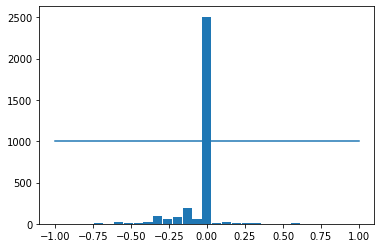

Removed Images: 1508
Remaining Images: 1633


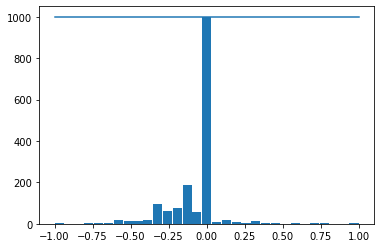

In [6]:
data = balanceData(data,display=True)

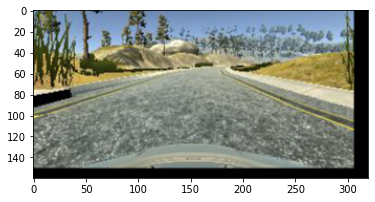

In [7]:
def augmentImage(imgPath,steering):
    ##pan
    img =  mpimg.imread(imgPath)
    if np.random.rand() < 0.5:
        pan = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
        img = pan.augment_image(img)
    ##zoom
    if np.random.rand() < 0.5:
        zoom = iaa.Affine(scale=(1, 1.2))
        img = zoom.augment_image(img)
    ##brightness
    if np.random.rand() < 0.5:
        brightness = iaa.Multiply((0.4, 1.2))
        img = brightness.augment_image(img)
    ##flip
    if np.random.rand() < 0.5:
        img = cv2.flip(img, 1)
        steering = -steering
    
    
    return img, steering
    
    
imgRe, st = augmentImage('Test.jpg',0)
plt.imshow(imgRe)
plt.show()

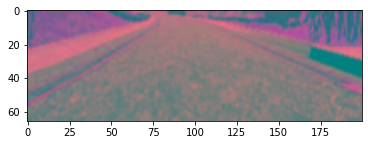

In [8]:
def preProcess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img
imgRe = preProcess(mpimg.imread('Test.jpg',0))
plt.imshow(imgRe)
plt.show()

In [9]:
def batchGen(imagesPath, steeringList, batchSize, trainFlag):
    while True:
        imgBatch = []
        steeringBatch = []
        for i in range(batchSize):
            index = random.randint(0, len(imagesPath) - 1)
            if trainFlag:
                img, steering = augmentImage(imagesPath[index], steeringList[index])
            else:
                img = mpimg.imread(imagesPath[index])
                steering = steeringList[index]
            img = preProcess(img)
            imgBatch.append(img)
            steeringBatch.append(steering)
        yield (np.asarray(imgBatch),np.asarray(steeringBatch))

In [10]:
def createModel():
    model = Sequential()
    
    model.add(Convolution2D(24, (5, 5), (2, 2), input_shape=(66, 200, 3), activation='elu'))
    model.add(Convolution2D(36, (5, 5), (2, 2), activation='elu'))
    model.add(Convolution2D(48, (5, 5), (2, 2), activation='elu'))
    model.add(Convolution2D(64, (3, 3), activation='elu'))
    model.add(Convolution2D(64, (3, 3), activation='elu'))
    
    model.add(Flatten())
    model.add(Dense(100, activation = 'elu'))
    model.add(Dense(50, activation = 'elu'))
    model.add(Dense(10, activation = 'elu'))
    model.add(Dense(1))
    
    model.compile(Adam(lr=0.0001),loss='mse')
    return model

model = createModel()
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               1

Epoch 1/10
300/300 [==============================] - 326s 1s/step - loss: 0.0173 - val_loss: 0.0198
Epoch 2/10
300/300 [==============================] - 306s 1s/step - loss: 0.0154 - val_loss: 0.0176
Epoch 3/10
300/300 [==============================] - 306s 1s/step - loss: 0.0157 - val_loss: 0.0170
Epoch 4/10
300/300 [==============================] - 223s 742ms/step - loss: 0.0151 - val_loss: 0.0182
Epoch 5/10
300/300 [==============================] - 190s 633ms/step - loss: 0.0151 - val_loss: 0.0171
Epoch 6/10
300/300 [==============================] - 190s 635ms/step - loss: 0.0141 - val_loss: 0.0162
Epoch 7/10
300/300 [==============================] - 192s 639ms/step - loss: 0.0142 - val_loss: 0.0153
Epoch 8/10
300/300 [==============================] - 195s 649ms/step - loss: 0.0136 - val_loss: 0.0149
Epoch 9/10
300/300 [==============================] - 221s 737ms/step - loss: 0.0125 - val_loss: 0.0144
Epoch 10/10
300/300 [==============================] - 230s 766ms/step - 

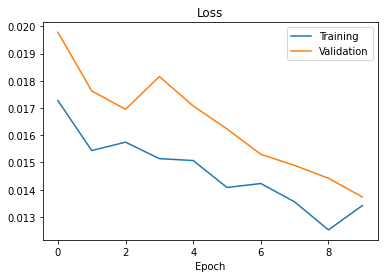

In [11]:
history = model.fit(batchGen(xTrain, yTrain, 100, 1),steps_per_epoch=300,epochs=10,
                    validation_data=batchGen(xVal, yVal, 100, 0),validation_steps=200)

model.save('model.h5')
print('Model Saved')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()